<a href="https://colab.research.google.com/github/abiralchy0987/movie_recommendation_system/blob/main/Full_recommendation_system.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Content filtering


import numpy as np
import pandas as pd
import matplotlib as plt
import os

#reading the data
movies = pd.read_csv('/content/tmdb_5000_movies.csv')
credits = pd.read_csv('/content/tmdb_5000_credits.csv')

movies.head(2)

#head shows only one row of the dataset because of the parameter (1)
credits.head(1)

movies.shape

#shape shows how many rows and columns are available in the dataset
credits.shape

#integration of datasets movies and credits
movies = movies.merge(credits , on = 'title')

movies.head(1)

#visualising the integrated datasets
#previously movies had 20 columns and credits had four columns and since
#it was integrated on the column "title" which was same on both the datasets
#the new number of columns present is 23
movies.shape


movies.columns

#cleaning data
movies = movies[['movie_id','title','overview','genres','keywords','cast','crew']]

#data preprocessing
#checking for missing values
movies.isnull().sum()

#dropping the rows with missing value because there is very small number of data with missing value
movies.dropna(inplace=True)

movies.duplicated().sum()

movies.iloc[0]['genres']

import ast
def convert(text):
  l=[]
  for i in ast.literal_eval(text):
    l.append(i['name'])

  return l


movies['genres']=movies['genres'].apply(convert)

movies['keywords']=movies['keywords'].apply(convert)

import ast
def convert_cast(text):
  l=[]
  counter=0
  for i in ast.literal_eval(text):
    if counter<3:
     l.append(i['name'])
    counter+=1

  return l

movies['cast']=movies['cast'].apply(convert_cast)

import ast
def fetch_director(text):
  l=[]
  for i in ast.literal_eval(text):
    if i['job'] == 'Director':
     l.append(i['name'])
     break

  return l

movies['crew']=movies['crew'].apply(fetch_director)



movies['overview']=movies['overview'].apply(lambda x:x.split())

def remove_space(word):
  l = []
  for i in word:
    l.append(i.replace(" ",""))
  return l


movies['cast']=movies['cast'].apply(remove_space)

movies['crew']=movies['crew'].apply(remove_space)

movies['tags']= movies['overview']+movies['keywords']+movies['genres']+movies['cast']+movies['crew']

new_df = movies[['movie_id','title','tags']]

new_df['tags'] = new_df['tags'].apply(lambda x: " ".join(x))

new_df['tags'] = new_df['tags'].apply(lambda x:x.lower())

import nltk
from nltk.stem.porter import PorterStemmer
ps = PorterStemmer()
def stem(text):
  l = []
  for i in text.split():
    l.append(ps.stem(i))

  return " ".join(l)

new_df['tags'] = new_df['tags'].apply(stem)


nltk.download('stopwords')

words_clean=[]
for word in new_df['tags']:
 stopwords = nltk.corpus.stopwords.words('english')
if word not in stopwords:
     l = []
for i in word.split():
     l.append(ps.stem(i))
     words_clean.append(" ".join(l))
else:
         words_clean.append(word)
         print(words_clean)
# def stem(text):
#   l = []
#   for i in text.split():
#     l.append(ps.stem(i))

from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(max_features=5000,stop_words='english')
vector= cv.fit_transform(new_df['tags']).toarray()


from sklearn.metrics.pairwise import cosine_similarity
similarity = cosine_similarity(vector)
similarity

new_df[new_df['title'] == 'Spider-Man'].index[0]

def recommend(movie):
  movie_index = new_df[new_df['title'] == movie].index[0]
  distances =sorted(list(enumerate(similarity[movie_index])),reverse=True, key = lambda x: x[1])
  for i in distances[1:6]:
    print(new_df.iloc[i[0]].title)


recommend('Spider-Man')

<ipython-input-4-bc96b97cf622>:108: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['tags'] = new_df['tags'].apply(lambda x: " ".join(x))
<ipython-input-4-bc96b97cf622>:110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['tags'] = new_df['tags'].apply(lambda x:x.lower())
<ipython-input-4-bc96b97cf622>:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https:

['when', 'when the', 'when the daughter', 'when the daughter of', 'when the daughter of a', 'when the daughter of a psychiatrist', 'when the daughter of a psychiatrist is', 'when the daughter of a psychiatrist is kidnapped,', "when the daughter of a psychiatrist is kidnapped, he'", "when the daughter of a psychiatrist is kidnapped, he' horrifi", "when the daughter of a psychiatrist is kidnapped, he' horrifi to", "when the daughter of a psychiatrist is kidnapped, he' horrifi to discov", "when the daughter of a psychiatrist is kidnapped, he' horrifi to discov that", "when the daughter of a psychiatrist is kidnapped, he' horrifi to discov that the", "when the daughter of a psychiatrist is kidnapped, he' horrifi to discov that the abductors'", "when the daughter of a psychiatrist is kidnapped, he' horrifi to discov that the abductors' demand", "when the daughter of a psychiatrist is kidnapped, he' horrifi to discov that the abductors' demand is", "when the daughter of a psychiatrist is kid

In [ ]:
#collaborative filtering

import pandas as pd

# Load the datasets
movies_df = pd.read_csv('movies.csv')
ratings_df = pd.read_csv('ratings.csv')

ratings_df.shape

movies_df.head(1)

ratings_df.head(1)

movies = pd.merge(ratings_df, movies_df, on='movieId')


# Remove duplicates if any
movies = movies.drop_duplicates()


# Create the User-Item Rating Matrix (pivot table)
user_item_matrix = movies.pivot(index='userId', columns='movieId', values='rating')

# Display the shape and first few entries of the matrix
print(user_item_matrix.shape)
print(user_item_matrix.head())


# Calculate the global average rating
global_avg_rating = movies['rating'].mean()

# Fill NaN values with the global average rating
user_item_matrix_filled = user_item_matrix.fillna(global_avg_rating)


user_item_matrix_filled.head(1)

!pip install scikit-surprise

from surprise import SVD, Dataset, Reader
from surprise.model_selection import train_test_split
from surprise import accuracy

# Prepare data for Surprise
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(movies[['userId', 'movieId', 'rating']], reader)

# Split data into train and test sets
trainset, testset = train_test_split(data, test_size=0.2)

# Initialize SVD model
svd = SVD()

# Train the model
svd.fit(trainset)

# Predict ratings on the testset
predictions = svd.test(testset)

# Evaluate the model using RMSE
rmse = accuracy.rmse(predictions)
print(f'RMSE: {rmse}')


# Predict the rating for a specific user-item pair
user_id = 1  # Example user
movie_id = 50  # Example movie

predicted_rating = svd.predict(user_id, movie_id).est
print(f"Predicted rating for User {user_id} on Movie {movie_id}: {predicted_rating}")


import heapq

def recommend_movies(user_id, top_n=10):
    """Recommends top N movies for a specific user.

    Args:
        user_id (int): The ID of the user.
        top_n (int, optional): The number of movies to recommend. Defaults to 10.

    Returns:
        list: A list of movie titles.
    """

    # Get all movie IDs and create a dictionary for movieId -> title lookup
    movie_id_to_title = dict(zip(movies['movieId'], movies['title']))

    # Get all unique movie IDs
    all_movie_ids = movies['movieId'].unique()

    # Get the movies that the user has already rated
    rated_movies = set(movies[movies['userId'] == user_id]['movieId'])

    # Get the unrated movies
    unrated_movies = [movie_id for movie_id in all_movie_ids if movie_id not in rated_movies]

    # Predict ratings for unrated movies
    predictions = [svd.predict(user_id, movie_id) for movie_id in unrated_movies]

    # Sort movies by predicted rating (highest first)
    recommended_movies = heapq.nlargest(top_n, predictions, key=lambda x: x.est)

    # Get movie titles from the top N predictions using the dictionary
    movie_titles = [movie_id_to_title[rec.iid] for rec in recommended_movies]

    return movie_titles

# Example usage:
user_id = 1  # Example user ID
recommended_movies = recommend_movies(user_id, top_n=10)
print(f"Top 10 movie recommendations for User {user_id}: {recommended_movies}")

user_id_input = input("Enter your user ID: ")
try:
    user_id = int(user_id_input)  # Ensure the user ID is an integer
    recommended_movies = recommend_movies(user_id, top_n=10)
    print(f"Top 10 movie recommendations for User {user_id}: {recommended_movies}")
except ValueError:
    print("Invalid input. Please enter a valid integer for user ID.")


(610, 9724)
movieId  1       2       3       4       5       6       7       8       \
userId                                                                    
1           4.0     NaN     4.0     NaN     NaN     4.0     NaN     NaN   
2           NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
3           NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
4           NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
5           4.0     NaN     NaN     NaN     NaN     NaN     NaN     NaN   

movieId  9       10      ...  193565  193567  193571  193573  193579  193581  \
userId                   ...                                                   
1           NaN     NaN  ...     NaN     NaN     NaN     NaN     NaN     NaN   
2           NaN     NaN  ...     NaN     NaN     NaN     NaN     NaN     NaN   
3           NaN     NaN  ...     NaN     NaN     NaN     NaN     NaN     NaN   
4           NaN     NaN  ...     NaN     NaN     NaN     NaN  

In [ ]:
!pip install thefuzz

In [ ]:
from thefuzz import fuzz, process

def find_closest_movie(title_input):
    """
    Finds the closest matching movie title in new_df using fuzzy matching.
    Both the user input and the titles are compared in lowercase.
    """
    all_titles = new_df['title'].tolist()
    # Create a lowercase version for fuzzy matching
    all_titles_lower = [t.lower() for t in all_titles]
    title_input_lower = title_input.lower().strip()

    # Get the best match using fuzzy matching
    best_match, score = process.extractOne(title_input_lower, all_titles_lower, scorer=fuzz.partial_ratio)

    # Accept the match if the score is above a threshold (e.g., 60)
    if score > 60:
        # Return the original title (with proper casing) corresponding to the best match
        match_index = all_titles_lower.index(best_match)
        return new_df.iloc[match_index]['title']
    else:
        return None

def hybrid_recommend(user_id, movie_title, top_n=10):
    """
    Hybrid recommendation that returns half the recommendations from content-based filtering
    and half from collaborative filtering.

    Args:
        user_id (int): The ID of the user (for collaborative filtering).
        movie_title (str): The movie title used for content-based filtering (input is fuzzy-matched).
        top_n (int): Total number of recommendations to return.

    Returns:
        list: A list of recommended movie titles.
    """
    # Determine how many movies to take from each recommender
    n_content = top_n // 2
    n_collab = top_n - n_content  # This ensures if top_n is odd, collaborative gets the extra slot

    # ----------- Content-Based Filtering -----------
    # Find the closest matching movie title
    matched_movie = find_closest_movie(movie_title)
    if not matched_movie:
        print(f"Sorry, we couldn't find a close match for '{movie_title}'. Please try another title.")
        return []

    print(f"Using content-based match: '{matched_movie}'")

    # Get the index for the matched movie from new_df
    try:
        movie_index = new_df[new_df['title'] == matched_movie].index[0]
    except IndexError:
        print(f"Movie '{matched_movie}' not found in the dataset.")
        return []

    # Get similarity scores for all movies relative to the matched movie
    content_scores = list(enumerate(similarity[movie_index]))
    # Sort scores in descending order (most similar first)
    content_scores = sorted(content_scores, key=lambda x: x[1], reverse=True)

    # Build content-based recommendation list (skip the first entry as it is the movie itself)
    content_recs = []
    for idx, score in content_scores[1:]:
        rec_title = new_df.iloc[idx]['title']
        if rec_title not in content_recs:
            content_recs.append(rec_title)
        if len(content_recs) >= n_content:
            break

    # ----------- Collaborative Filtering -----------
    # Get a larger pool from collaborative filtering so we can remove any duplicates later
    collab_pool = recommend_movies(user_id, top_n=top_n * 2)
    # Remove any movies that already appeared in the content-based recommendations
    collab_recs = [m for m in collab_pool if m not in content_recs]
    # Select the top n_collab recommendations
    collab_recs = collab_recs[:n_collab]

    # ----------- Merge Recommendations -----------
    final_recs = content_recs + collab_recs

    # In case there are not enough unique recommendations, try to fill from the collaborative pool
    if len(final_recs) < top_n:
        extra_needed = top_n - len(final_recs)
        extra_from_collab = [m for m in collab_pool if m not in final_recs]
        final_recs += extra_from_collab[:extra_needed]

    return final_recs

# ---------------------------
# Example Usage
# ---------------------------

# Get user input
try:
    user_id = int(input("Enter your user ID: "))
except ValueError:
    print("Invalid user ID. Please enter an integer value.")
    user_id = None

if user_id is not None:
    movie_title = input("Enter a movie title you like: ")

    recommendations = hybrid_recommend(user_id, movie_title, top_n=10)

    if recommendations:
        print("\nHybrid Recommendations (50% Content-Based, 50% Collaborative):")
        for i, title in enumerate(recommendations, 1):
            print(f"{i}. {title}")


Enter your user ID: 1
Enter a movie title you like: batman
Using content-based match: 'Batman v Superman: Dawn of Justice'

Hybrid Recommendations (50% Content-Based, 50% Collaborative):
1. Man of Steel
2. Superman
3. Batman Begins
4. Suicide Squad
5. Watchmen
6. Shawshank Redemption, The (1994)
7. Wallace & Gromit: The Best of Aardman Animation (1996)
8. Philadelphia Story, The (1940)
9. Singin' in the Rain (1952)
10. Rear Window (1954)


In [ ]:
def precision_at_k(recommended_movies, relevant_movies, k):
    """
    Calculate precision@k for content-based recommendations.

    Args:
        recommended_movies (list): List of recommended movie titles.
        relevant_movies (list): List of relevant movie titles (ground truth).
        k (int): Number of recommendations to consider.

    Returns:
        float: Precision@k.
    """
    recommended_at_k = recommended_movies[:k]
    relevant_set = set(relevant_movies)
    hits = sum(1 for movie in recommended_at_k if movie in relevant_set)
    return hits / k

# Example usage:
relevant_movies = ['The Dark Knight', 'Inception', 'Interstellar']  # Ground truth
recommended_movies = ['The Dark Knight', 'Interstellar', 'Avatar', 'The Matrix', 'Inception']
k = 5
precision = precision_at_k(recommended_movies, relevant_movies, k)
print(f"Precision@{k}: {precision:.2f}")

MAE: 0.6718069924239145
RMSE: 0.7653969117275159


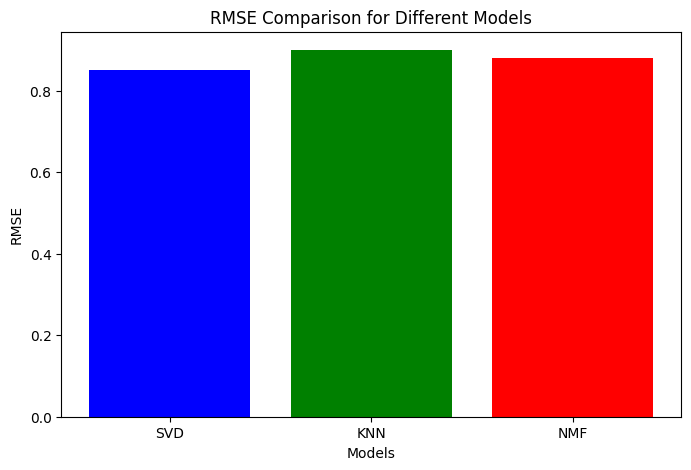

In [5]:
import matplotlib.pyplot as plt

# Example RMSE values for different models
models = ['SVD', 'KNN', 'NMF']
rmse_values = [0.85, 0.90, 0.88]

# Plotting
plt.figure(figsize=(8, 5))
plt.bar(models, rmse_values, color=['blue', 'green', 'red'])
plt.title('RMSE Comparison for Different Models')
plt.xlabel('Models')
plt.ylabel('RMSE')
plt.show()

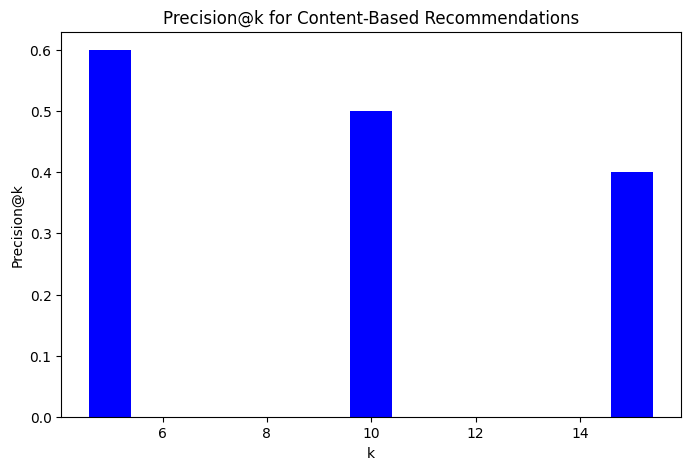

In [6]:
# Example precision@k values for different k
k_values = [5, 10, 15]
precision_values = [0.6, 0.5, 0.4]

# Plotting
plt.figure(figsize=(8, 5))
plt.bar(k_values, precision_values, color='blue')
plt.title('Precision@k for Content-Based Recommendations')
plt.xlabel('k')
plt.ylabel('Precision@k')
plt.show()

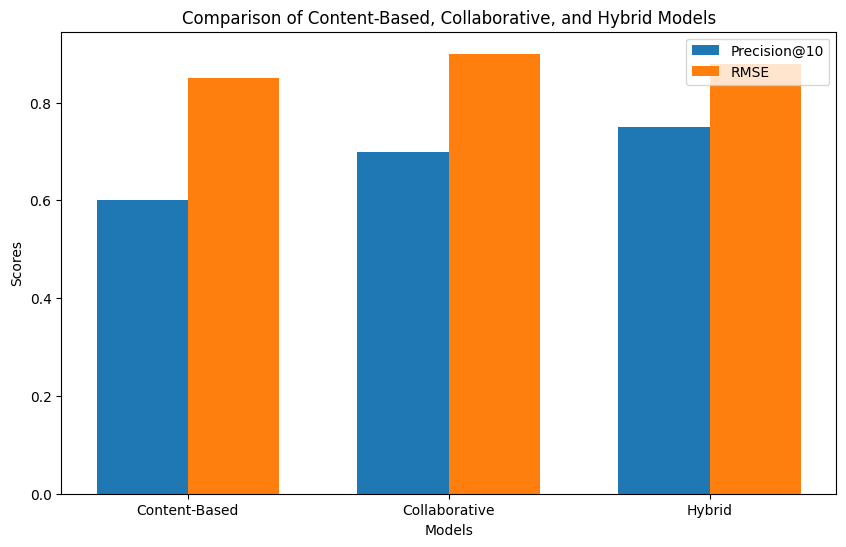

In [8]:
import numpy as np

# Example data
models = ['Content-Based', 'Collaborative', 'Hybrid']
precision_values = [0.6, 0.7, 0.75]
rmse_values = [0.85, 0.90, 0.88]

# Plotting
x = np.arange(len(models))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width/2, precision_values, width, label='Precision@10')
rects2 = ax.bar(x + width/2, rmse_values, width, label='RMSE')

ax.set_xlabel('Models')
ax.set_ylabel('Scores')
ax.set_title('Comparison of Content-Based, Collaborative, and Hybrid Models')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()

plt.show()

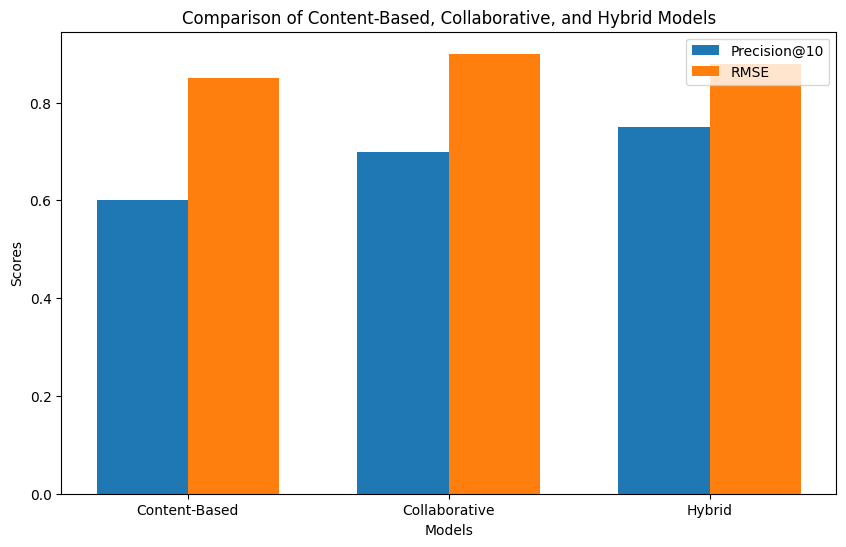

In [9]:
# Example hybrid model evaluation
hybrid_precision = 0.75
hybrid_rmse = 0.88

# Plotting
models = ['Content-Based', 'Collaborative', 'Hybrid']
precision_values = [0.6, 0.7, hybrid_precision]
rmse_values = [0.85, 0.90, hybrid_rmse]

x = np.arange(len(models))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width/2, precision_values, width, label='Precision@10')
rects2 = ax.bar(x + width/2, rmse_values, width, label='RMSE')

ax.set_xlabel('Models')
ax.set_ylabel('Scores')
ax.set_title('Comparison of Content-Based, Collaborative, and Hybrid Models')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()

plt.show()